paper{https://arxiv.org/pdf/1412.6574.pdf}

In [70]:
import cv2
img = cv2.imread("D:/Rohit/ORG India/images/1.png") #D:\Rohit\ORG India\images\image_effect_HUc1.png

In [71]:
img.shape

(690, 480, 3)

In [96]:
w = img.shape[0]#275
h = img.shape[1]#393
c = 3
L = 6

In [97]:
wl = []
hl = []
s  = []
centers = dict()
for l in range(2,L+1):
    wi = (2 * w)/(l+1)
    hi = (2 * h)/(l+1)
    s_val = max(wi,hi)
    s.append(s_val)
    wl.append(wi)
    hl.append(hi)
    it_centers = []
    for i in range(1,l+1):
        for j in range(1,l+1):
            bw =  (w-wi)/(l-1)
            bh =  (h-hi)/(l-1)
            cx =  (wi/2) + (i-1)*bw
            cy =  (hi/2) + (j-1)*bh
            it_centers.append([int(cx),int(cy)])
    centers[int(s_val)] = it_centers
    

In [98]:
def patches(side,center,image):
    h,w,c = image.shape
    half_side = side / 2
    left_corner_x = int(center[0] - half_side) 
    left_corner_y = int(center[1] - half_side)
    if(left_corner_x < 0):
        left_corner_x = 0
    if(left_corner_y < 0):
        left_corner_y = 0
    stridex = int(left_corner_x+side)
    stridey = int(left_corner_y+side)
    if(stridex>h):
        stridex = int(left_corner_x + side-(stridex-h))
    if(stridey>w):
        stridey = int(left_corner_y + side-(stridey-w))
    #print(left_corner_x,stridex,left_corner_y,stridey)
    image_patch = image[left_corner_x:stridex,left_corner_y:stridey,:]
    return(image_patch)

In [99]:
import numpy as np

In [100]:
all_patches = []
for sides,allcenters in centers.items():
    for single_centers in allcenters:
        all_patches.append(patches(sides,single_centers,img))

In [101]:
assert len(all_patches)+1 == sum([i**2 for i in range(1,L+1)])

In [102]:
import cv2
import matplotlib.pyplot as plt

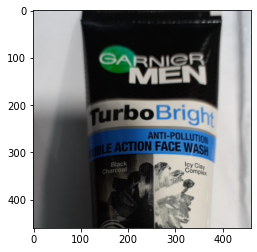

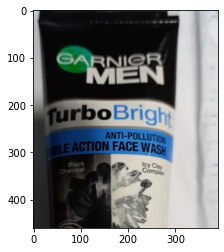

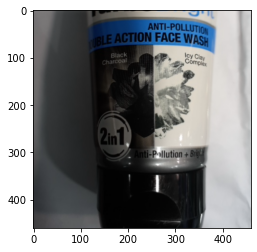

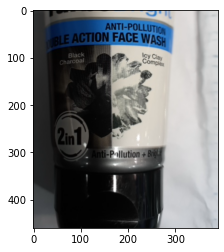

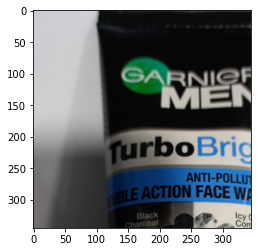

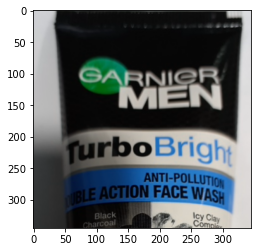

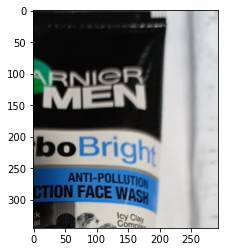

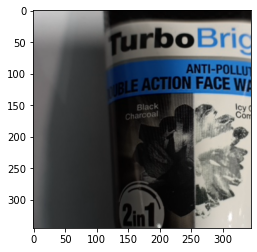

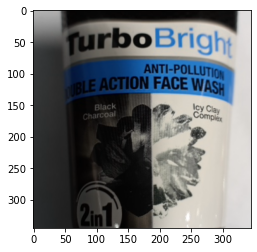

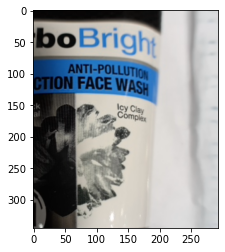

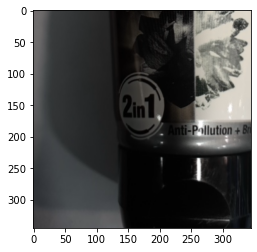

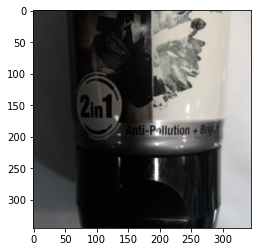

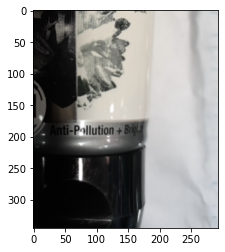

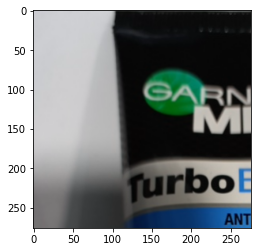

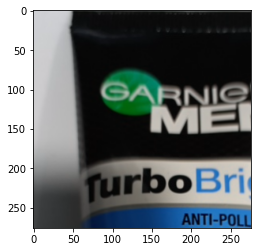

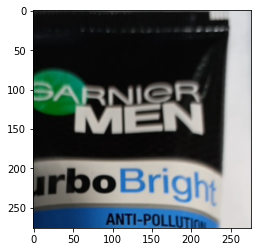

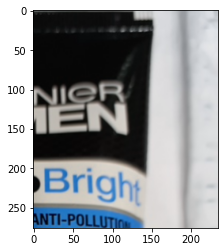

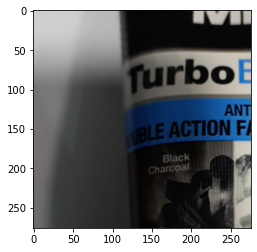

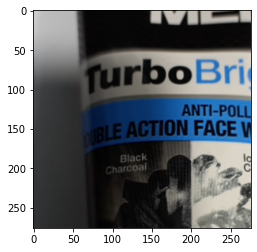

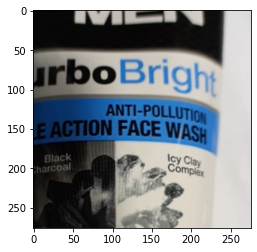

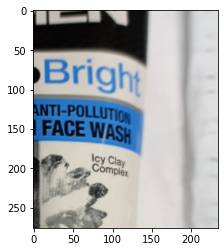

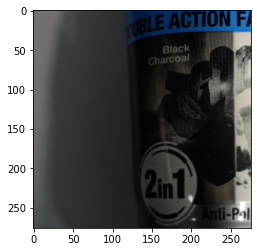

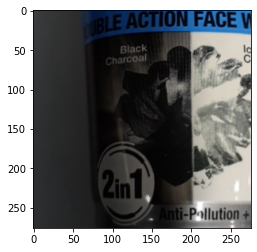

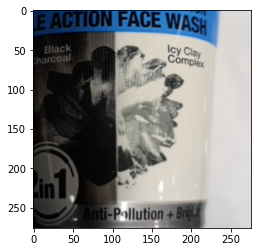

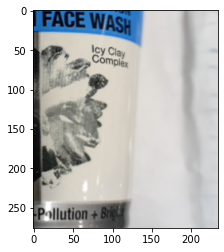

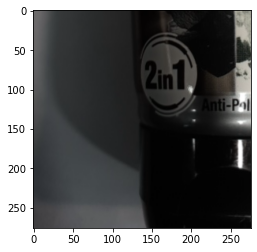

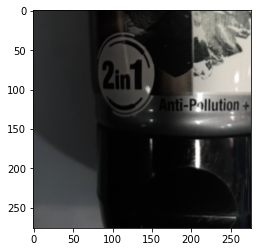

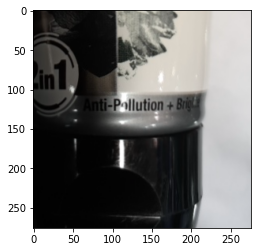

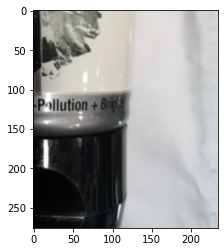

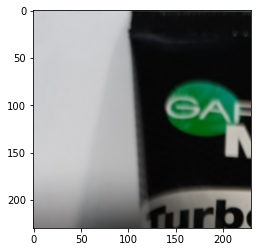

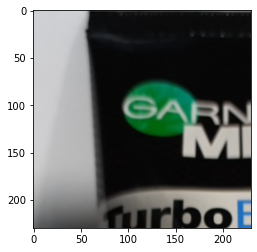

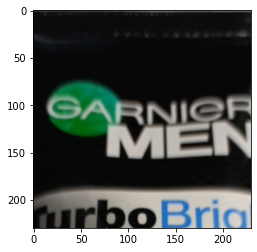

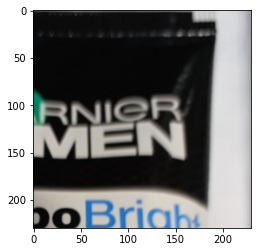

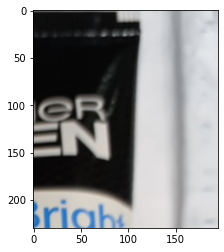

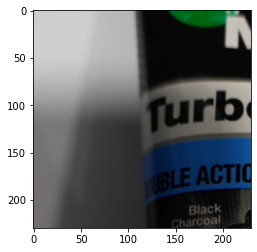

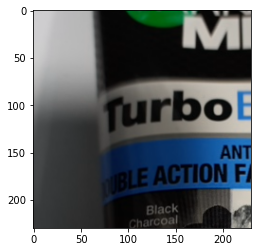

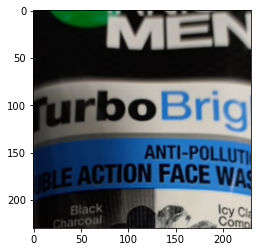

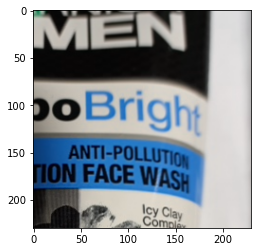

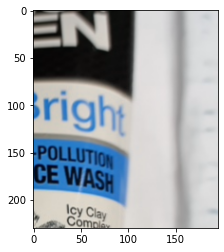

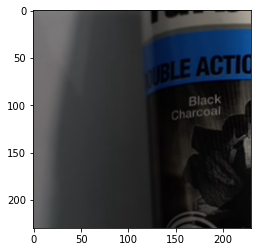

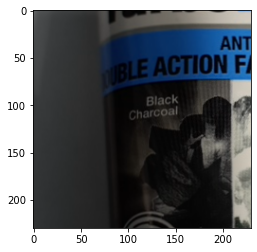

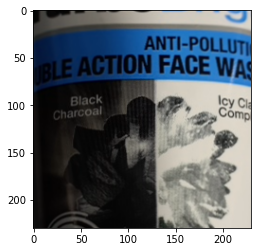

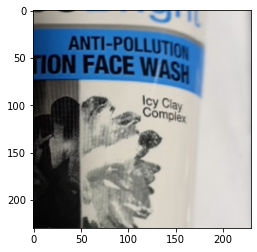

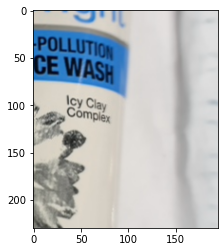

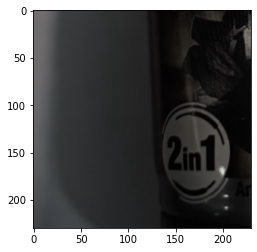

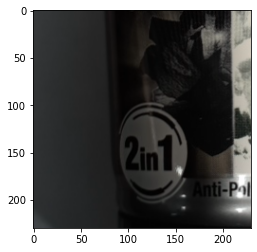

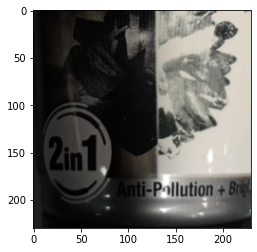

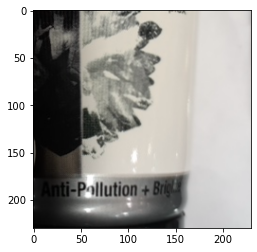

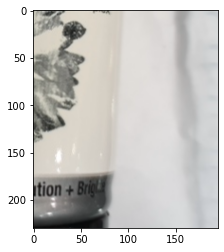

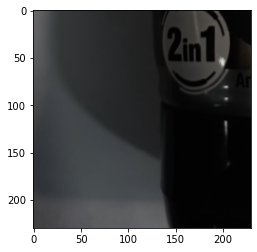

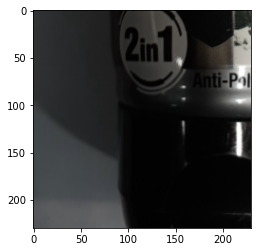

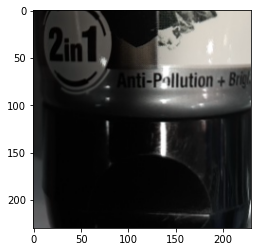

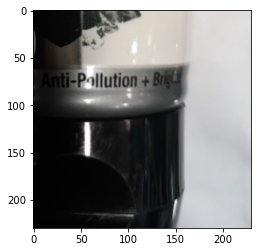

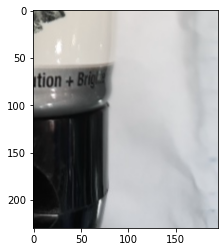

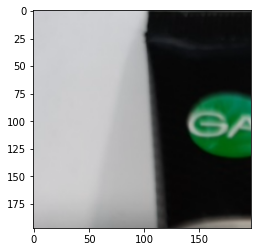

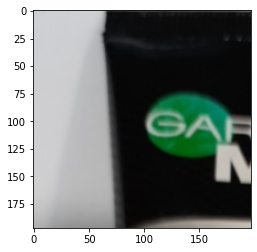

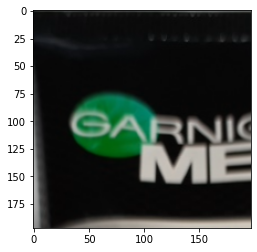

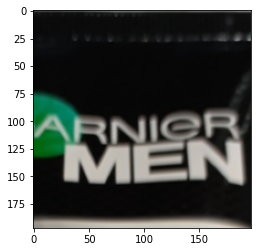

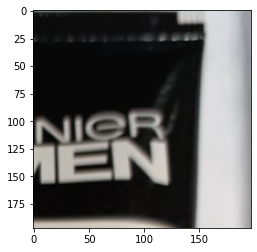

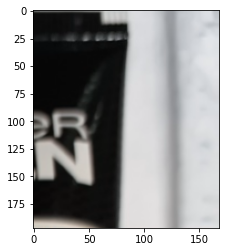

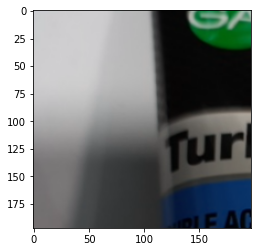

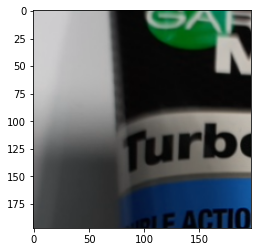

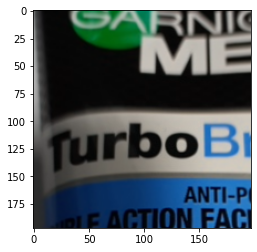

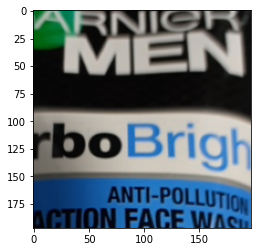

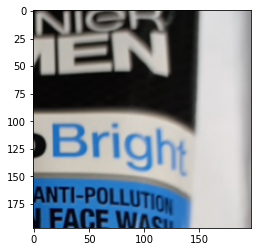

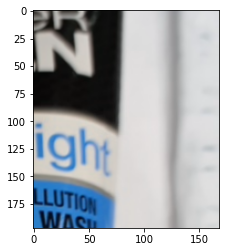

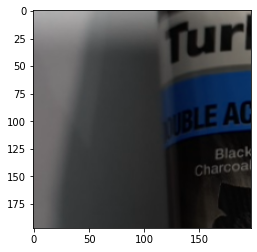

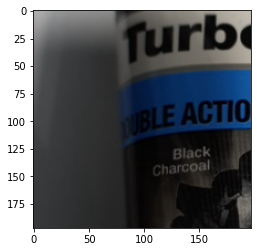

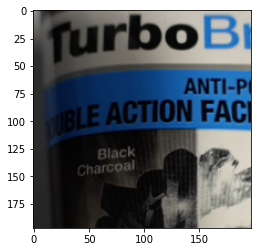

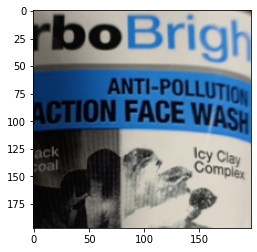

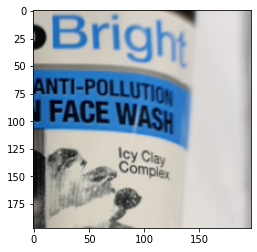

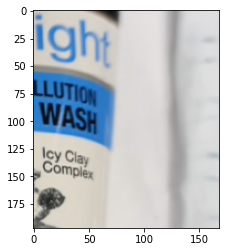

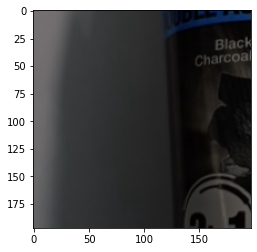

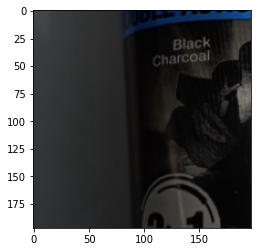

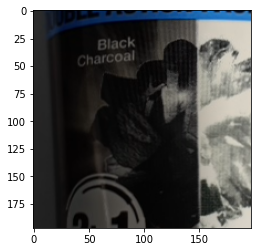

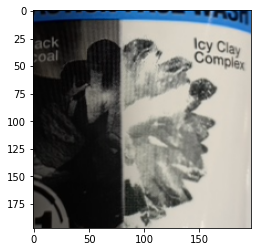

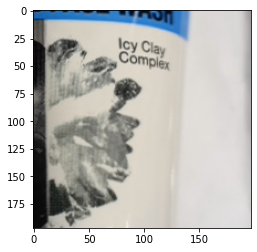

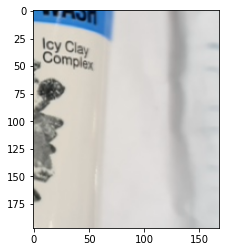

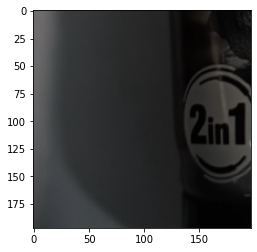

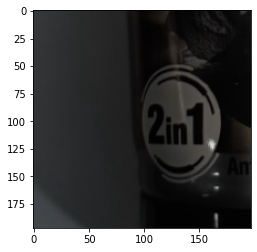

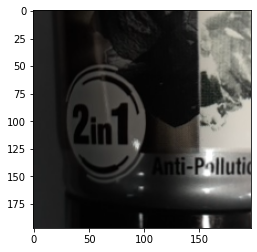

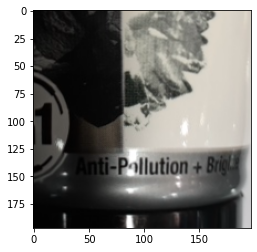

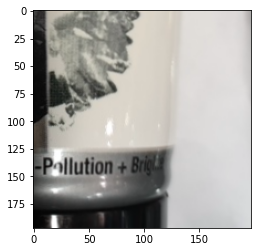

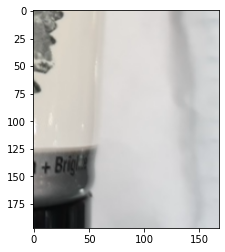

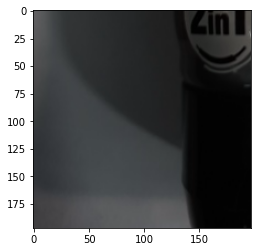

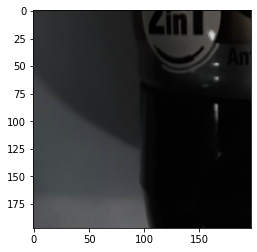

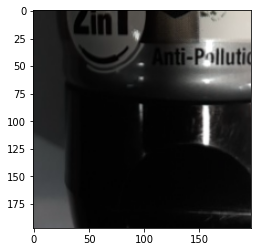

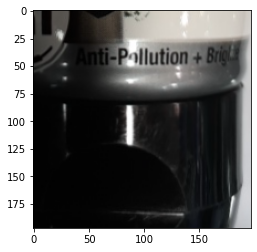

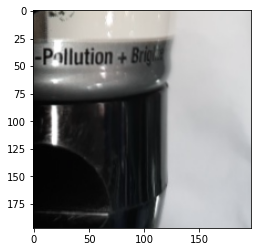

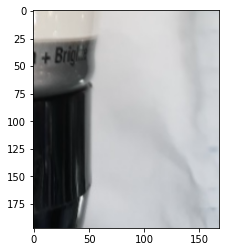

In [103]:
for sap in all_patches:
    plt.imshow(sap)
    plt.show()

In [104]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
import re
convname = re.compile(r'conv2d_*')
convlayerlist = []
for layers in model.layers:
    mo1 = bool(re.match(convname,layers.name))
    if(mo1):
        convlayerlist.append(layers.name)



In [105]:
lastconvfeature = tf.keras.Model(
    inputs = model.inputs,
    outputs= model.get_layer(convlayerlist[-1]).output)

In [106]:
lastconvfeature(tf.ones((1,299,299,3))).shape

TensorShape([1, 8, 8, 192])

In [107]:
model.get_layer(convlayerlist[-1]).output.shape

TensorShape([None, 8, 8, 192])

In [108]:
lastconvoutput = lastconvfeature(tf.ones((1,299,299,3)))
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(8, 8),strides=(1, 1), padding='valid')

In [109]:
finalfeature = max_pool_2d(lastconvoutput)

Pending work
- pge 4, Howto resize all the patches to 299,299,3 to pass thriught the cnn
- implment the distance algorithm
- implement jittering

In [110]:
def extractfeature(ap):
    resized_ap = np.resize(ap,(1,299,299,3))
    lastconvoutput = lastconvfeature(resized_ap)
    finalfeature = max_pool_2d(lastconvoutput)
    finalfeature = np.squeeze(finalfeature)
    return finalfeature


In [111]:
extractedfeature = []
for ap in all_patches:
    returnedfeature = extractfeature(ap)
    extractedfeature.append(returnedfeature)

In [118]:
originalimage = cv2.imread("./images/10.png")
originalImageFeature = extractfeature(originalimage)

In [123]:
distlist = []
for ef in extractedfeature:
    dist = np.linalg.norm(ef - originalImageFeature)
    distlist.append(dist)

In [124]:
min(distlist)

46.840687

In [125]:
import os
path = "images"
listdir = os.listdir(path)
minindex = 1000
for i in listdir:
    distlist = []
    originalimage = cv2.imread(os.path.join("D:/Rohit/ORG India/images",i))
    originalImageFeature = extractfeature(originalimage)
    for ef in extractedfeature:
        dist = np.linalg.norm(ef - originalImageFeature)
        distlist.append(dist)
    if(min(distlist)<minindex):
        minindex = min(distlist)
        minindexpath = i

In [126]:
minindexpath

'10.png'